# Preamble

In [1]:
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

In [2]:
# Whether or not to save matplotlib figures as pdf output file for latex
USE_LATEX_ENGINE = True

if USE_LATEX_ENGINE:
    import matplotlib
    # matplotlib.use("pgf")     # pgf doesn't work for some plots because they exceed the max value that pgf can calculate
    matplotlib.rcParams.update({
        # "pgf.texsystem": "pdflatex",
        # 'pgf.rcfonts': False,
        'font.family': 'serif',
        'text.usetex': True,
    })

# Function Definitions

In [3]:
def _generate_output_string(element, data):
    """
    Returns a string that contains information about the percentual share of a value in a list
    """
    # if not isinstance(element, str): # make sure element is of type string, convert otherwise
    #     element = str(element)
    
    n_total = len(data)
    bool_list = (data == element)
    n_elements = sum(bool_list)

    return "{:<30}".format(str(n_elements) + '/' + str(n_total) + ' (' + "{:.2f}".format(((n_elements / n_total) * 100)) + '%)')

In [4]:
def calculate_percentages(normal_data, pneumonia_data, additional_df=None):
    """
    checks if two lists contain the same set of values - returns a warning if the sets dont match - prints a string with information about the distribution if they match
    """
    if len(set(normal_data)) is not len(set(pneumonia_data)):
        print('WARNING! Categories of healthy and pneumonia data are not identical!')
        print('Normal: ' + str(set(normal_data)))
        print('Pneumonia: ' + str(set(pneumonia_data)))
        print('Number of appearences (normal):')
        n_normal_set = ''
        for category in set(normal_data):
            n_normal_set += "'" + str(category) + "': " + str(sum(normal_data == category)) + '\n'   # single quote: non-escaped string, double quote: escaped string
        print(n_normal_set)
        return
    else:
        print(set(normal_data))
    if additional_df is None:
        print('{:<21}'.format('') + '{:<30}'.format('normal') + '{:<30}'.format('pneumonia'))
    else:
        print('{:<21}'.format('') + '{:<30}'.format('normal (total)') + '{:<30}'.format('normal (filtered)') + '{:<30}'.format('pneumonia'))

    for element in set(normal_data):
        category_string = "{:<21}".format(str(element) + ': ')
        if additional_df is None:
            print(category_string + _generate_output_string(element, normal_data) + _generate_output_string(element, pneumonia_data))
        else:
            print(category_string + _generate_output_string(element, normal_data) + _generate_output_string(element, additional_df) + _generate_output_string(element, pneumonia_data))

In [5]:
def find_appearences(df, column, value):
    """
    searches for appearences of a specified value within the column of a dataframe - prints the number of appearences and the corresponding indexes
    """
    
    value = str(value)
    print('found ' + str(sum(df[column] == value)) + ' rows')
    index_list = df.index[df[column] == value].tolist()
    print('Indexes: ' + str(index_list))
    return index_list

In [6]:
def drop_from_column(df, column, value):
    """
    searches for appearences of a specified value within a column of a dataframe - drops each row where the value appeared from the dataframe
    """
    value = str(value)
    print('Dropping ' + str(sum(df[column] == value)) + ' rows')
    index_list = df.index[df[column] == value].tolist()
    df.drop(index_list, inplace=True)

# Data preparation

In [7]:
normal_meta_data = '/mnt/c/Users/Jan/Daten/Geschäftlich/Capgemini/scripts/tmp/filtered_PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv'
pneumonia_meta_data = '/mnt/c/Users/Jan/Daten/Geschäftlich/Capgemini/scripts/tmp/filtered_pneumonia.csv'

# read csv files, engine='python' improves parsing, column differentiation, etc.
normal_meta_data = pd.read_csv(normal_meta_data, engine='python')
pneumonia_meta_data = pd.read_csv(pneumonia_meta_data, engine='python')
normal_meta_data.reset_index(drop=True, inplace=True)
pneumonia_meta_data.reset_index(drop=True, inplace=True)

In [8]:
replace_nan_with = 'U'      # U for Unknown
print('Replacing ' + str(normal_meta_data.isnull().sum().sum()) + ' appearances of NaN with: ' + str(replace_nan_with))
normal_meta_data.fillna(replace_nan_with, inplace=True)   # be careful, this modifies the original dataframe

print('Replacing ' + str(pneumonia_meta_data.isnull().sum().sum()) + ' appearances of NaN with: ' + str(replace_nan_with))
pneumonia_meta_data.fillna(replace_nan_with, inplace=True)   # be careful, this modifies the original dataframe

Replacing 11003 appearances of NaN with: U
Replacing 3891 appearances of NaN with: U


In [9]:
qry = ''
qry = qry + 'Labels.str.contains("normal")'
qry = qry + ' & Labels.str.contains("pneumonia")'
print(qry)
res_norm = normal_meta_data.query(qry, engine='python')
res_pneu = pneumonia_meta_data.query(qry, engine='python')

print('Found', len(res_norm), 'overlappings in normal meta data and', len(res_pneu), 'in pneumonia meta data')

Labels.str.contains("normal") & Labels.str.contains("pneumonia")
Found 2 overlappings in normal meta data and 3 in pneumonia meta data


In [10]:
print(len(normal_meta_data))
normal_meta_data.drop(res_norm.index, inplace=True)
print(len(normal_meta_data))

print(len(pneumonia_meta_data))
pneumonia_meta_data.drop(res_pneu.index, inplace=True)
print(len(pneumonia_meta_data))

36324
36322
5241
5238


In [11]:
FIRST_GROUP_BOUNDARY = 12
SECOND_GROUP_BOUNDARY = 62

drop_from_column(normal_meta_data, 'PatientBirth', 'U') # drop unknown birth years, since there's only one entry

# This is clearly not the fastest way to do this, as using df.loc in loops is not recommended
for df in [normal_meta_data, pneumonia_meta_data]:
    i = 0
    for row in df.itertuples():
        age = int(str(row.StudyDate_DICOM)[:4]) - int(row.PatientBirth)
        df.loc[row.Index, 'Age'] = age

        if 0 <= age <= FIRST_GROUP_BOUNDARY:
            df.loc[row.Index, 'AgeGroup'] = int(1)
        elif FIRST_GROUP_BOUNDARY < age <= SECOND_GROUP_BOUNDARY:
            df.loc[row.Index, 'AgeGroup'] = int(2)
        elif SECOND_GROUP_BOUNDARY < age:
            df.loc[row.Index, 'AgeGroup'] = int(3)
        else:
            raise ValueError("Calculated age was either below 0 or a non numerical type")

        if str(row.Projection) == 'AP_horizontal':
            i += 1
            df.loc[row.Index, 'ProjectionSimplified'] = 'AP'
        else:
            df.loc[row.Index, 'ProjectionSimplified'] = row.Projection
    print('Replaced AP_horizontal with AP', i, 'times')


Dropping 1 rows
Replaced AP_horizontal with AP 1101 times
Replaced AP_horizontal with AP 1330 times


# Data Analysis

In [12]:
print('==== Distribution of projections ====\n')

calculate_percentages(normal_meta_data['Projection'], pneumonia_meta_data['Projection'])

find_appearences(normal_meta_data, 'Projection', 'UNK')
drop_from_column(normal_meta_data, 'Projection', 'UNK')

drop_from_column(normal_meta_data, 'Projection', 'COSTAL')
drop_from_column(pneumonia_meta_data, 'Projection', 'COSTAL')

calculate_percentages(normal_meta_data['Projection'], pneumonia_meta_data['Projection'])

==== Distribution of projections ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'PA', 'AP_horizontal', 'COSTAL', 'AP', 'UNK'}
Pneumonia: {'PA', 'COSTAL', 'AP', 'AP_horizontal'}
Number of appearences (normal):
'PA': 34366
'AP_horizontal': 1101
'COSTAL': 220
'AP': 633
'UNK': 1

found 1 rows
Indexes: [31563]
Dropping 1 rows
Dropping 220 rows
Dropping 18 rows
{'PA', 'AP', 'AP_horizontal'}
                     normal                        pneumonia                     
PA:                  34366/36100 (95.20%)          3400/5220 (65.13%)            
AP:                  633/36100 (1.75%)             490/5220 (9.39%)              
AP_horizontal:       1101/36100 (3.05%)            1330/5220 (25.48%)            


In [13]:
calculate_percentages(normal_meta_data['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'])
calculate_percentages(normal_meta_data['AgeGroup'], pneumonia_meta_data['AgeGroup'])

{'PA', 'AP'}
                     normal                        pneumonia                     
PA:                  34366/36100 (95.20%)          3400/5220 (65.13%)            
AP:                  1734/36100 (4.80%)            1820/5220 (34.87%)            
{1.0, 2.0, 3.0}
                     normal                        pneumonia                     
1.0:                 1873/36100 (5.19%)            929/5220 (17.80%)             
2.0:                 25070/36100 (69.45%)          1754/5220 (33.60%)            
3.0:                 9157/36100 (25.37%)           2537/5220 (48.60%)            


In [14]:
print('==== Distribution of MethodLabel ====\n')

calculate_percentages(normal_meta_data['MethodLabel'], pneumonia_meta_data['MethodLabel'])

==== Distribution of MethodLabel ====

{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           8925/36100 (24.72%)           1094/5220 (20.96%)            
RNN_model:           27175/36100 (75.28%)          4126/5220 (79.04%)            


In [15]:
print('==== Distribution of Patient Sex ====\n')

calculate_percentages(normal_meta_data['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])


==== Distribution of Patient Sex ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'U', 'M', 'O', 'F'}
Pneumonia: {'M', 'F'}
Number of appearences (normal):
'U': 3
'M': 15374
'O': 4
'F': 20719



In [16]:
calculate_percentages(normal_meta_data['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])

drop_from_column(normal_meta_data, 'PatientSex_DICOM', 'U')     # drop 'U' and 'O' since they are heavily underrepresented
drop_from_column(normal_meta_data, 'PatientSex_DICOM', 'O')

calculate_percentages(normal_meta_data['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'U', 'M', 'O', 'F'}
Pneumonia: {'M', 'F'}
Number of appearences (normal):
'U': 3
'M': 15374
'O': 4
'F': 20719

Dropping 3 rows
Dropping 4 rows
{'M', 'F'}
                     normal                        pneumonia                     
M:                   15374/36093 (42.60%)          2962/5220 (56.74%)            
F:                   20719/36093 (57.40%)          2258/5220 (43.26%)            


In [17]:
print('==== Distribution of ExposureTime ====\n')

calculate_percentages(normal_meta_data['ExposureTime'], pneumonia_meta_data['ExposureTime'])


==== Distribution of ExposureTime ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'11', '19', '25', '5', '32', '47', '18', '64', '50', '14', '17', '160', '20', '0', '7', '85', '1', '3', 'None', '12', '352', '16', '4', '500', '15', '40', '8', '6', '33', '55', '10', '80', '2', '13', '9'}
Pneumonia: {'11', '25', '5', '64', '50', '20', '0', '7', '3', 'None', '12', '16', '4', '8', '6', '10', '80', '2', '13', '9'}
Number of appearences (normal):
'11': 48
'19': 1
'25': 104
'5': 2171
'32': 2
'47': 1
'18': 1
'64': 17
'50': 7
'14': 9
'17': 2
'160': 2
'20': 4
'0': 3211
'7': 490
'85': 1
'1': 1
'3': 158
'None': 7667
'12': 100
'352': 1
'16': 30
'4': 687
'500': 2
'15': 4
'40': 1
'8': 903
'6': 1323
'33': 1
'55': 1
'10': 18920
'80': 1
'2': 12
'13': 17
'9': 193



In [18]:
calculate_percentages(normal_meta_data['Exposure_DICOM'], pneumonia_meta_data['Exposure_DICOM'])

filtered_exposure_normal = [int(x) for x in normal_meta_data['Exposure_DICOM'] if str(x) != 'None']
filtered_exposure_pneumonia = [int(x) for x in pneumonia_meta_data['Exposure_DICOM'] if str(x) != 'None']
print(len(filtered_exposure_normal))
print(len(filtered_exposure_pneumonia))


WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'11', '25', '5', '20', '0', '30', '7', '1', '3', 'None', '12', '4', '40', '8', '35', '6', '10', '80', '2'}
Pneumonia: {'8', '1', '3', '0', 'None', '6', '20', '10', '12', '2', '4', '25', '5'}
Number of appearences (normal):
'11': 1
'25': 2
'5': 52
'20': 7
'0': 3211
'30': 1
'7': 1
'1': 1746
'3': 5604
'None': 7667
'12': 45
'4': 219
'40': 1
'8': 12
'35': 1
'6': 40
'10': 29
'80': 2
'2': 17452

28426
2664


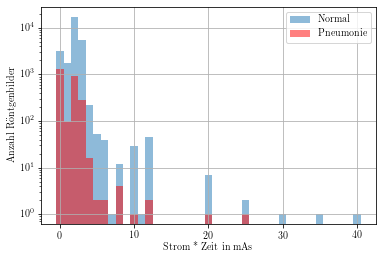

In [19]:
filtered_exposure_normal = sorted(filtered_exposure_normal)
filtered_exposure_pneumonia = sorted(filtered_exposure_pneumonia)

fig, ax_exp_time = plt.subplots()  # a figure with a single Axes

ax_exp_time.set_yscale('log')   # logarithmic scale on y axis

# bins must be -0.5 to center the x ticks, for detailled explanation see https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
ax_exp_time.hist(filtered_exposure_normal, np.arange(42)-0.5, alpha=0.5, label="Normal")
ax_exp_time.hist(filtered_exposure_pneumonia, np.arange(42)-0.5, alpha=0.5, color='r', label="Pneumonie")
ax_exp_time.set_xlabel('Strom * Zeit in mAs')
ax_exp_time.set_ylabel('Anzahl Röntgenbilder')
ax_exp_time.legend()
ax_exp_time.grid(True)

if USE_LATEX_ENGINE:
    plt.savefig("/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_combined_exposure.pdf")

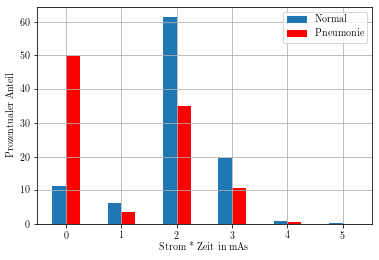

In [20]:
exposure_percentage_normal = [(filtered_exposure_normal.count(x)*100) / len(filtered_exposure_normal) for x in np.arange(42)]
exposure_percentage_pneumonia = [(filtered_exposure_pneumonia.count(x)*100) / len(filtered_exposure_pneumonia) for x in np.arange(42)]

fig, ax = plt.subplots()  # a figure with a single Axes

# bins must be -0.5 to center the x ticks, for detailled explanation see https://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
ax.bar(np.arange(6)-0.125, exposure_percentage_normal[:6], width=0.25, label="Normal")
ax.bar(np.arange(6)+0.125, exposure_percentage_pneumonia[:6], color='r', width=0.25, label="Pneumonie")
ax.set_xlabel('Strom * Zeit in mAs')
ax.set_ylabel('Prozentualer Anteil')
ax.legend()
ax.grid(True)

if USE_LATEX_ENGINE:
    plt.savefig("/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_combined_exposure_percentage.pdf")

In [21]:
print('==== Distribution of XRayTubeCurrent_DICOM ====\n')

calculate_percentages(normal_meta_data['XRayTubeCurrent_DICOM'], pneumonia_meta_data['XRayTubeCurrent_DICOM'])

==== Distribution of XRayTubeCurrent_DICOM ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'320', '160', '100', '250', '0', 'None', '125', '400', '200', '500'}
Pneumonia: {'320', '160', '100', '250', '0', 'None', '400', '200', '500'}
Number of appearences (normal):
'320': 4693
'160': 32
'100': 74
'250': 13962
'0': 3211
'None': 10707
'125': 2
'400': 1923
'200': 17
'500': 1472



In [22]:
print('==== Distribution of Exposure_DICOM ====\n')

calculate_percentages(normal_meta_data['Exposure_DICOM'], pneumonia_meta_data['Exposure_DICOM'])


==== Distribution of Exposure_DICOM ====

WARNING! Categories of healthy and pneumonia data are not identical!
Normal: {'11', '25', '5', '20', '0', '30', '7', '1', '3', 'None', '12', '4', '40', '8', '35', '6', '10', '80', '2'}
Pneumonia: {'8', '1', '3', '0', 'None', '6', '20', '10', '12', '2', '4', '25', '5'}
Number of appearences (normal):
'11': 1
'25': 2
'5': 52
'20': 7
'0': 3211
'30': 1
'7': 1
'1': 1746
'3': 5604
'None': 7667
'12': 45
'4': 219
'40': 1
'8': 12
'35': 1
'6': 40
'10': 29
'80': 2
'2': 17452



In [23]:
print('==== Distribution of Modality_DICOM ====\n')

calculate_percentages(normal_meta_data['Modality_DICOM'], pneumonia_meta_data['Modality_DICOM'])

==== Distribution of Modality_DICOM ====

{'DX', 'CR'}
                     normal                        pneumonia                     
DX:                  3133/36093 (8.68%)            234/5220 (4.48%)              
CR:                  32960/36093 (91.32%)          4986/5220 (95.52%)            


In [24]:
print('==== Distribution of Manufacturer_DICOM ====\n')

calculate_percentages(normal_meta_data['Manufacturer_DICOM'], pneumonia_meta_data['Manufacturer_DICOM'])

==== Distribution of Manufacturer_DICOM ====

{'PhilipsMedicalSystems', 'ImagingDynamicsCompanyLtd'}
                     normal                        pneumonia                     
PhilipsMedicalSystems: 13894/36093 (38.49%)          4106/5220 (78.66%)            
ImagingDynamicsCompanyLtd: 22199/36093 (61.51%)          1114/5220 (21.34%)            


In [25]:
print('==== Distribution of PixelAspectRatio_DICOM ====\n')
calculate_percentages(normal_meta_data['PixelAspectRatio_DICOM'], pneumonia_meta_data['PixelAspectRatio_DICOM'])

==== Distribution of PixelAspectRatio_DICOM ====

{'None', "['1', '1']"}
                     normal                        pneumonia                     
None:                29426/36093 (81.53%)          2111/5220 (40.44%)            
['1', '1']:          6667/36093 (18.47%)           3109/5220 (59.56%)            


In [26]:
print('==== Distribution of Age ====\n')
calculate_percentages(normal_meta_data['PatientBirth'], pneumonia_meta_data['PatientBirth'])

==== Distribution of Age ====

{1907.0, 1911.0, 1912.0, 1914.0, 1915.0, 1916.0, 1917.0, 1918.0, 1919.0, 1920.0, 1921.0, 1922.0, 1923.0, 1924.0, 1925.0, 1926.0, 1927.0, 1928.0, 1929.0, 1930.0, 1931.0, 1932.0, 1933.0, 1934.0, 1935.0, 1936.0, 1937.0, 1938.0, 1939.0, 1940.0, 1941.0, 1942.0, 1943.0, 1944.0, 1945.0, 1946.0, 1947.0, 1948.0, 1949.0, 1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0, 1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0, 1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0, 1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0, 1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0}
                     normal                        pneumonia                     
1907.0:              1/36093 (0.00%)  

In [27]:
normal_age_list = list()
number_of_normal = list()
for y in set(normal_meta_data['PatientBirth']):
    normal_age_list += [int(y)]
    number_of_normal += [sum(normal_meta_data['PatientBirth'] == y)]

print(normal_age_list)
print(number_of_normal)

[1907, 1911, 1912, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
[1, 2, 2, 3, 2, 8, 10, 8, 14, 7, 32, 40, 37, 47, 99, 92, 112, 118, 150, 186, 201, 210, 294, 339, 336, 345, 366, 371, 325, 500, 378, 361, 485, 563, 529, 578, 608, 585, 560, 524, 599, 584, 607, 598, 624, 636, 699, 691, 734, 728, 727, 764, 754, 781, 769, 789, 780, 805, 709, 827, 709, 727, 736, 659, 637, 542, 502, 492, 481, 420, 382, 340, 317, 335, 315, 305, 266, 3

In [28]:
pneumonia_age_list = list()
number_of_pneumonia = list()
for y in set(pneumonia_meta_data['PatientBirth']):
    pneumonia_age_list += [int(y)]
    number_of_pneumonia += [sum(pneumonia_meta_data['PatientBirth'] == y)]

print(pneumonia_age_list)
print(number_of_pneumonia)

[1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
[3, 1, 3, 7, 9, 9, 13, 8, 22, 23, 43, 42, 42, 61, 46, 49, 75, 100, 80, 114, 84, 121, 109, 94, 92, 99, 97, 97, 68, 107, 94, 78, 114, 96, 79, 80, 102, 81, 87, 63, 73, 54, 44, 55, 71, 59, 60, 57, 55, 50, 43, 58, 58, 56, 54, 54, 55, 29, 44, 49, 46, 49, 39, 45, 38, 28, 34, 26, 30, 16, 22, 17, 25, 25, 11, 13, 22, 23, 13, 9, 7, 12, 16, 5, 13, 4, 13, 10, 16, 13, 26, 17

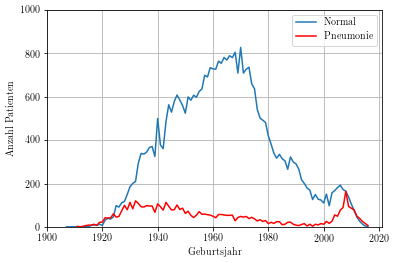

In [29]:
plt.axis([1900, 2021 , 0, 1001])
plt.plot(normal_age_list, number_of_normal, label="Normal")
plt.plot(pneumonia_age_list, number_of_pneumonia, 'r', label="Pneumonie")
plt.ylabel('Anzahl Patienten')
plt.xlabel('Geburtsjahr')
plt.legend()
plt.grid(True)
# plt.show()

if USE_LATEX_ENGINE:
    plt.savefig('/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/year_of_birth_diagram.pdf')


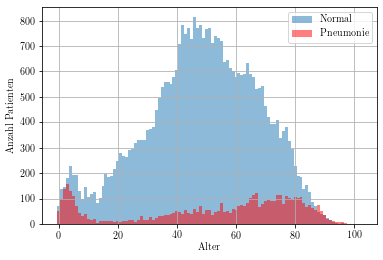

In [30]:
maximum_age = max(max(set(normal_meta_data['Age'])), max(set(pneumonia_meta_data['Age'])))
x_axis_age = np.arange(maximum_age + 2)-0.5 # would be +1 for right aligned, but we want to center the x ticks -> +0.5
plt.hist(normal_meta_data['Age'], x_axis_age, alpha=0.5, label="Normal")
plt.hist(pneumonia_meta_data['Age'], x_axis_age, alpha=0.5, color='r', label="Pneumonie")
plt.ylabel('Anzahl Patienten')
plt.xlabel('Alter')
plt.legend()
plt.grid(True)
# plt.show()

if USE_LATEX_ENGINE:
    plt.savefig('/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_age_histogram.pdf')


In [31]:
set(normal_meta_data)

{'Age',
 'AgeGroup',
 'BitsStored_DICOM',
 'Columns_DICOM',
 'ExposureInuAs_DICOM',
 'ExposureTime',
 'Exposure_DICOM',
 'ImageDir',
 'ImageID',
 'Labels',
 'LabelsLocalizationsBySentence',
 'Localizations',
 'LocalizationsCUIS',
 'Manufacturer_DICOM',
 'MethodLabel',
 'MethodProjection',
 'Modality_DICOM',
 'PatientBirth',
 'PatientID',
 'PatientSex_DICOM',
 'Pediatric',
 'PhotometricInterpretation_DICOM',
 'PixelAspectRatio_DICOM',
 'PixelRepresentation_DICOM',
 'Projection',
 'ProjectionSimplified',
 'RelativeXRayExposure_DICOM',
 'Report',
 'ReportID',
 'Rows_DICOM',
 'SpatialResolution_DICOM',
 'StudyDate_DICOM',
 'StudyID',
 'Unnamed: 0',
 'Unnamed: 0.1',
 'ViewPosition_DICOM',
 'WindowCenter_DICOM',
 'WindowWidth_DICOM',
 'XRayTubeCurrent_DICOM',
 'labelCUIS'}

In [32]:
duplicate_patients = set(normal_meta_data['PatientID']) & set(pneumonia_meta_data['PatientID'])
print(str(len(duplicate_patients)) + ' Patients are both in Normal and Pneumonia data present')
print('Total number of Patients:\nNormal: ' + str(len(set(normal_meta_data['PatientID']))) + '\nPneumonia: ' + str(len(set(pneumonia_meta_data['PatientID']))))

718 Patients are both in Normal and Pneumonia data present
Total number of Patients:
Normal: 29986
Pneumonia: 4210


In [33]:
qry = ''
first = True
for id in list(duplicate_patients):
    if first:
        qry = qry + 'PatientID == \'' + str(id) + '\''
        first = False
    else:
        qry = qry + ' | PatientID == \'' + str(id) + '\''
duplicate_df = normal_meta_data.query(qry)

In [34]:
calculate_percentages(normal_meta_data['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'])
calculate_percentages(duplicate_df['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'])

{'PA', 'AP'}
                     normal                        pneumonia                     
PA:                  34359/36093 (95.20%)          3400/5220 (65.13%)            
AP:                  1734/36093 (4.80%)            1820/5220 (34.87%)            
{'PA', 'AP'}
                     normal                        pneumonia                     
PA:                  876/957 (91.54%)              3400/5220 (65.13%)            
AP:                  81/957 (8.46%)                1820/5220 (34.87%)            


# Filtering for final Dataset

## Patients who have images with and without pneumonia
All samples of these patients labeled with normal + projection PA will be removed from the dataset, to make sure their "normal" images don't show a light pneumonia.<br>
normal label + AP will be kept, as the combination of AP + normal is rare

In [35]:
print("Dropping", sum(duplicate_df['ProjectionSimplified'] == 'PA'), "samples labeled as normal + projection PA whose patients also have samples with pneumonia label")

print(len(normal_meta_data))
normal_meta_data.drop(duplicate_df.query("ProjectionSimplified == 'PA'").index, inplace=True)
print(len(normal_meta_data))



Dropping 876 samples labeled as normal + projection PA whose patients also have samples with pneumonia label
36093
35217


In [36]:
calculate_percentages(duplicate_df.query("ProjectionSimplified == 'AP'")['MethodLabel'], pneumonia_meta_data['MethodLabel'])
calculate_percentages(normal_meta_data['MethodLabel'], pneumonia_meta_data['MethodLabel'])

{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           6/81 (7.41%)                  1094/5220 (20.96%)            
RNN_model:           75/81 (92.59%)                4126/5220 (79.04%)            
{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           8812/35217 (25.02%)           1094/5220 (20.96%)            
RNN_model:           26405/35217 (74.98%)          4126/5220 (79.04%)            


# Experimantal random sampling

In [37]:

filtered_normal_meta = []
copy_normal_meta_imagingdynamics = normal_meta_data.loc[normal_meta_data['Manufacturer_DICOM'] == "ImagingDynamicsCompanyLtd"]
copy_normal_meta_philips = normal_meta_data.loc[normal_meta_data['Manufacturer_DICOM'] == "PhilipsMedicalSystems"]

random_imagingdynamics = copy_normal_meta_imagingdynamics.sample(n = 1114)
random_philips = copy_normal_meta_philips.sample(n = 4106)
random_normal = random_imagingdynamics.append(random_philips)
print(len(random_imagingdynamics))
print(len(random_philips))
print(len(random_normal))


1114
4106
5220


In [38]:
print('==== Distribution of projections ====\n')
calculate_percentages(normal_meta_data['Projection'], pneumonia_meta_data['Projection'], random_normal['Projection'])

==== Distribution of projections ====

{'PA', 'AP', 'AP_horizontal'}
                     normal (total)                normal (filtered)             pneumonia                     
PA:                  33483/35217 (95.08%)          4714/5220 (90.31%)            3400/5220 (65.13%)            
AP:                  633/35217 (1.80%)             191/5220 (3.66%)              490/5220 (9.39%)              
AP_horizontal:       1101/35217 (3.13%)            315/5220 (6.03%)              1330/5220 (25.48%)            


In [39]:
find_appearences(normal_meta_data, 'Projection', 'COSTAL')

found 0 rows
Indexes: []


[]

In [40]:

filtered_normal_meta = []
copy_normal_meta_imagingdynamics = normal_meta_data.loc[normal_meta_data['Manufacturer_DICOM'] == "ImagingDynamicsCompanyLtd"]
copy_normal_meta_philips = normal_meta_data.loc[normal_meta_data['Manufacturer_DICOM'] == "PhilipsMedicalSystems"]

random_imagingdynamics = copy_normal_meta_imagingdynamics.sample(n = 1116)
random_philips = copy_normal_meta_philips.sample(n = 4107)
random_normal = random_imagingdynamics.append(random_philips)

print("ImagingDynamics: " + str(len(random_imagingdynamics)) + '/' + str(len(copy_normal_meta_imagingdynamics)))
print("Philips; " + str(len(random_philips)) + '/' + str(len(copy_normal_meta_philips)))
print(len(random_normal))

# random_normal = normal_meta_data.sample(n = len(pneumonia_meta_data))

print('==== Distribution of projections ====\n')
calculate_percentages(normal_meta_data['Projection'], pneumonia_meta_data['Projection'], random_normal['Projection'])

ImagingDynamics: 1116/21608
Philips; 4107/13609
5223
==== Distribution of projections ====

{'PA', 'AP', 'AP_horizontal'}
                     normal (total)                normal (filtered)             pneumonia                     
PA:                  33483/35217 (95.08%)          4730/5223 (90.56%)            3400/5220 (65.13%)            
AP:                  633/35217 (1.80%)             164/5223 (3.14%)              490/5220 (9.39%)              
AP_horizontal:       1101/35217 (3.13%)            329/5223 (6.30%)              1330/5220 (25.48%)            


In [41]:
print('==== Distribution of Manufacturers ====\n')
calculate_percentages(normal_meta_data['Manufacturer_DICOM'], pneumonia_meta_data['Manufacturer_DICOM'], random_normal['Manufacturer_DICOM'])

==== Distribution of Manufacturers ====

{'PhilipsMedicalSystems', 'ImagingDynamicsCompanyLtd'}
                     normal (total)                normal (filtered)             pneumonia                     
PhilipsMedicalSystems: 13609/35217 (38.64%)          4107/5223 (78.63%)            4106/5220 (78.66%)            
ImagingDynamicsCompanyLtd: 21608/35217 (61.36%)          1116/5223 (21.37%)            1114/5220 (21.34%)            


In [42]:
print('==== Distribution of MethodLabel ====\n')
calculate_percentages(random_normal['MethodLabel'], pneumonia_meta_data['MethodLabel'])

==== Distribution of MethodLabel ====

{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           2034/5223 (38.94%)            1094/5220 (20.96%)            
RNN_model:           3189/5223 (61.06%)            4126/5220 (79.04%)            


In [43]:
print('==== Distribution of Patient Sex ====\n')
calculate_percentages(random_normal['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])

==== Distribution of Patient Sex ====

{'M', 'F'}
                     normal                        pneumonia                     
M:                   2280/5223 (43.65%)            2962/5220 (56.74%)            
F:                   2943/5223 (56.35%)            2258/5220 (43.26%)            


In [44]:
print('==== Distribution of Modality_DICOM ====\n')
calculate_percentages(random_normal['Modality_DICOM'], pneumonia_meta_data['Modality_DICOM'])

==== Distribution of Modality_DICOM ====

{'DX', 'CR'}
                     normal                        pneumonia                     
DX:                  943/5223 (18.05%)             234/5220 (4.48%)              
CR:                  4280/5223 (81.95%)            4986/5220 (95.52%)            


In [45]:
print('==== Distribution of Manufacturer_DICOM ====\n')
calculate_percentages(random_normal['Manufacturer_DICOM'], pneumonia_meta_data['Manufacturer_DICOM'])

==== Distribution of Manufacturer_DICOM ====

{'PhilipsMedicalSystems', 'ImagingDynamicsCompanyLtd'}
                     normal                        pneumonia                     
PhilipsMedicalSystems: 4107/5223 (78.63%)            4106/5220 (78.66%)            
ImagingDynamicsCompanyLtd: 1116/5223 (21.37%)            1114/5220 (21.34%)            


In [46]:
print('==== Distribution of MethodLabel ====\n')
calculate_percentages(random_normal['MethodLabel'], pneumonia_meta_data['MethodLabel'])

==== Distribution of MethodLabel ====

{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           2034/5223 (38.94%)            1094/5220 (20.96%)            
RNN_model:           3189/5223 (61.06%)            4126/5220 (79.04%)            


In [47]:
print('==== Distribution of MethodProjection ====\n')
calculate_percentages(random_normal['MethodProjection'], pneumonia_meta_data['MethodProjection'])

==== Distribution of MethodProjection ====

{'Manual review of DICOM fields', 'resnet-50.t7'}
                     normal                        pneumonia                     
Manual review of DICOM fields: 4268/5223 (81.72%)            4761/5220 (91.21%)            
resnet-50.t7:        955/5223 (18.28%)             459/5220 (8.79%)              


# Stratified Sampling from Kaggle

In [48]:
'''
This module contains functions that computes stratified sampling of pandas dataframes.
'''
# Required libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Functions

In [49]:
def __smpl_size(population, size):
    '''
    A function to compute the sample size. If not informed, a sampling 
    size will be calculated using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2

        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error

        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)

        where:
            - cochran_n = result of the previous formula
            - N is the population size
    Parameters
    ----------
        :population: population size
        :size: sample size (default = None)
    Returns
    -------
    Calculated sample size to be used in the functions:
        - stratified_sample
        - stratified_sample_report
    '''
    if size is None:
        cochran_n = round(((1.96)**2 * 0.5 * 0.5)/ 0.02**2)
        n = round(cochran_n/(1+((cochran_n -1) /population)))
    elif size >= 0 and size < 1:
        n = round(population * size)
    elif size < 0:
        raise ValueError('Parameter "size" must be an integer or a proportion between 0 and 0.99.')
    elif size >= 1:
        n = size
    return n

In [50]:
def stratified_sample_report(df, strata, size=None):
    '''
    Generates a dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.

    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2

        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error

        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)

        where:
            - cochran_n = result of the previous formula
            - N is the population size

    Returns
    -------
    A dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd


In [51]:
def stratified_sample(df, strata, size=None, seed=None, keep_index= True):
    '''
    It samples data from a pandas dataframe using strata. These functions use
    proportionate stratification:
    n1 = (N1/N) * n
    where:
        - n1 is the sample size of stratum 1
        - N1 is the population size of stratum 1
        - N is the total population size
        - n is the sampling size
    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    :seed: sampling seed
    :keep_index: if True, it keeps a column with the original population index indicator
    
    Returns
    -------
    A sampled pandas dataframe based in a set of strata.
    Examples
    --------
    >> df.head()
    	id  sex age city 
    0	123 M   20  XYZ
    1	456 M   25  XYZ
    2	789 M   21  YZX
    3	987 F   40  ZXY
    4	654 M   45  ZXY
    ...
    # This returns a sample stratified by sex and city containing 30% of the size of
    # the original data
    >> stratified = stratified_sample(df=df, strata=['sex', 'city'], size=0.3)
    Requirements
    ------------
    - pandas
    - numpy
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True 
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # final dataframe
        if first:
            stratified_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            first = False
        else:
            tmp_df = df.query(qry).sample(n=n, random_state=seed).reset_index(drop=(not keep_index))
            stratified_df = stratified_df.append(tmp_df, ignore_index=True)
    
    return stratified_df


In [52]:
def stratified_sample_report(df, strata, size=None):
    '''
    Generates a dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.

    Parameters
    ----------
    :df: pandas dataframe from which data will be sampled.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2

        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error

        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)

        where:
            - cochran_n = result of the previous formula
            - N is the population size

    Returns
    -------
    A dataframe reporting the counts in each stratum and the counts
    for the final sampled dataframe.
    '''
    population = len(df)
    size = __smpl_size(population, size)
    tmp = df[strata]
    tmp['size'] = 1
    tmp_grpd = tmp.groupby(strata).count().reset_index()
    tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)
    return tmp_grpd

In [53]:
def stratified_sample_transferred(df_target, df_proportion, strata, size=None, seed=None, keep_index= True):
    '''
    It samples data from a pandas dataframe using strata. These functions use
    proportionate stratification:
    n1 = (N1/N) * n
    where:
        - n1 is the sample size of stratum 1
        - N1 is the population size of stratum 1
        - N is the total population size
        - n is the sampling size
    Parameters
    ----------
    :df_target: pandas dataframe from which data will be sampled.
    :df_proportion: pandas dataframe from which the proportions for sampling will be used.
    :strata: list containing columns that will be used in the stratified sampling.
    :size: sampling size. If not informed, a sampling size will be calculated
        using Cochran adjusted sampling formula:
        cochran_n = (Z**2 * p * q) /e**2
        where:
            - Z is the z-value. In this case we use 1.96 representing 95%
            - p is the estimated proportion of the population which has an
                attribute. In this case we use 0.5
            - q is 1-p
            - e is the margin of error
        This formula is adjusted as follows:
        adjusted_cochran = cochran_n / 1+((cochran_n -1)/N)
        where:
            - cochran_n = result of the previous formula
            - N is the population size
    :seed: sampling seed
    :keep_index: if True, it keeps a column with the original population index indicator
    
    Returns
    -------
    A sampled pandas dataframe based in a set of strata.
    Examples
    --------
    >> df.head()
    	id  sex age city 
    0	123 M   20  XYZ
    1	456 M   25  XYZ
    2	789 M   21  YZX
    3	987 F   40  ZXY
    4	654 M   45  ZXY
    ...
    # This returns a sample stratified by sex and city containing 30% of the size of
    # the original data
    >> stratified = stratified_sample(df=df, strata=['sex', 'city'], size=0.3)
    Requirements
    ------------
    - pandas
    - numpy
    '''
    
    # population = len(df)
    # size = __smpl_size(population, size)
    # tmp = df[strata]
    # tmp['size'] = 1
    # tmp_grpd = tmp.groupby(strata).count().reset_index()
    # tmp_grpd['samp_size'] = round(size/population * tmp_grpd['size']).astype(int)


    population = len(df_proportion)
    size = __smpl_size(population, size)

    tmp_proportion = df_proportion[strata]
    tmp = df_target[strata]

    tmp_proportion['size'] = 1
    tmp['size'] = 1

    tmp_proportion_grpd = tmp_proportion.groupby(strata).count().reset_index()
    tmp_grpd = tmp.groupby(strata).count().reset_index()

    if not tmp_grpd[strata].equals(tmp_proportion_grpd[strata]):
        print(tmp_grpd)
        print(tmp_proportion_grpd)
        raise ValueError("Dataframes don't have the same groups for the given set of stratas. You can check the differences in the terminal output.")        

    tmp_proportion_grpd['samp_size'] = round(size/population * tmp_proportion_grpd['size']).astype(int)
    tmp_grpd['samp_size'] = round(size/population * tmp_proportion_grpd['size']).astype(int)

    # controlling variable to create the dataframe or append to it
    first = True
    # Hier muss nichts geändert werden, da die Gruppen ohnehin die gleichen sein sollten -> len(tmp_grpd) == len(tmp_proportion_grpd)
    for i in range(len(tmp_grpd)):
        # query generator for each iteration
        qry=''
        for s in range(len(strata)):
            stratum = strata[s]
            # Hier wird n berechnet, tmp_proportion_grpd statt tmp_grpd
            
            value = tmp_grpd.iloc[i][stratum]
            n = tmp_grpd.iloc[i]['samp_size']

            if type(value) == str:
                value = "'" + str(value) + "'"
            
            if s != len(strata)-1:
                qry = qry + stratum + ' == ' + str(value) +' & '
            else:
                qry = qry + stratum + ' == ' + str(value)
        
        # query dataframe
        queried_df = df_target.query(qry)

        # check if result contains enough samples / rows
        if len(queried_df) < n:
            print("Warning! The required number of samples (" + str(n) + ") could not be retrieved.")
            print("Using all available entries (" + str(len(queried_df)) + ") of group:")
            print(qry)
            n = len(queried_df)

        # sample dataframe
        sampled_df = queried_df.sample(n=n, random_state=seed).reset_index(drop=(not keep_index))

        # assign to final dataframe
        if first:
            stratified_df = sampled_df
            first = False
        else:
            stratified_df = stratified_df.append(sampled_df, ignore_index=True)
    
    return stratified_df

In [54]:
stratified_sample_report(normal_meta_data, ['Manufacturer_DICOM', 'Projection', 'PatientSex_DICOM'], size=2000)


,Manufacturer_DICOM,Projection,PatientSex_DICOM,size,samp_size
0,ImagingDynamicsCompanyLtd,AP,F,62,4
1,ImagingDynamicsCompanyLtd,AP,M,76,4
2,ImagingDynamicsCompanyLtd,PA,F,12452,707
3,ImagingDynamicsCompanyLtd,PA,M,9018,512
4,PhilipsMedicalSystems,AP,F,215,12
5,PhilipsMedicalSystems,AP,M,280,16
6,PhilipsMedicalSystems,AP_horizontal,F,469,27
7,PhilipsMedicalSystems,AP_horizontal,M,632,36
8,PhilipsMedicalSystems,PA,F,7051,400
9,PhilipsMedicalSystems,PA,M,4962,282


In [55]:
indexes = find_appearences(normal_meta_data, 'Projection', 'AP_horizontal')

found 1101 rows
Indexes: [12, 42, 52, 107, 146, 147, 155, 213, 227, 271, 292, 321, 323, 348, 363, 376, 411, 482, 504, 534, 760, 785, 912, 1031, 1090, 1169, 1245, 1430, 1454, 1455, 1483, 1484, 1504, 1563, 1574, 1631, 1646, 1667, 1681, 1698, 1802, 1831, 1844, 1895, 1918, 1935, 2067, 2275, 2375, 2376, 2385, 2661, 2675, 2721, 2845, 2878, 2951, 2952, 2986, 3069, 3135, 3235, 3305, 3312, 3341, 3425, 3457, 3623, 3666, 3675, 3680, 3845, 3850, 3883, 4065, 4086, 4088, 4259, 4309, 4319, 4376, 4545, 4916, 4969, 5027, 5031, 5033, 5199, 5201, 5377, 5414, 5445, 5531, 5562, 5717, 5794, 5935, 5992, 5997, 6021, 6125, 6187, 6287, 6328, 6359, 6493, 6569, 6570, 6631, 7003, 7019, 7024, 7071, 7254, 7263, 7275, 7290, 7328, 7459, 7463, 7693, 7744, 7772, 7841, 7851, 7857, 7861, 7880, 7916, 7946, 7982, 8177, 8201, 8228, 8317, 8411, 8488, 8490, 8518, 8617, 8637, 8816, 8863, 8872, 8938, 8952, 8964, 8988, 9021, 9035, 9049, 9078, 9105, 9166, 9184, 9193, 9270, 9273, 9330, 9350, 9353, 9358, 9363, 9411, 9429, 9465, 9494

In [56]:
# import matplotlib.image as mpimg
# import random

# fig_nr = 1

# for i in random.sample(indexes, 10):
#     plt.figure(fig_nr)
#     fig_nr += 1
#     img = mpimg.imread('/mnt/f/BIMCV-PadChest/unzipped/' + str(normal_meta_data.loc[i]['ImageDir']) + '/' + str(normal_meta_data.loc[i]['ImageID']))
#     imgplot = plt.imshow(img, cmap="gray")
# plt.show()

In [57]:
stratified_sample_report(normal_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'ProjectionSimplified', 'AgeGroup'])

,Manufacturer_DICOM,Modality_DICOM,PatientSex_DICOM,ProjectionSimplified,AgeGroup,size,samp_size
0,ImagingDynamicsCompanyLtd,CR,F,AP,1.0,7,0
1,ImagingDynamicsCompanyLtd,CR,F,AP,2.0,33,2
2,ImagingDynamicsCompanyLtd,CR,F,AP,3.0,22,1
3,ImagingDynamicsCompanyLtd,CR,F,PA,1.0,216,14
4,ImagingDynamicsCompanyLtd,CR,F,PA,2.0,8841,564
5,ImagingDynamicsCompanyLtd,CR,F,PA,3.0,3395,217
6,ImagingDynamicsCompanyLtd,CR,M,AP,1.0,21,1
7,ImagingDynamicsCompanyLtd,CR,M,AP,2.0,38,2
8,ImagingDynamicsCompanyLtd,CR,M,AP,3.0,17,1
9,ImagingDynamicsCompanyLtd,CR,M,PA,1.0,320,20


In [58]:
stratified_sample_report(pneumonia_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'ProjectionSimplified', 'AgeGroup'])

,Manufacturer_DICOM,Modality_DICOM,PatientSex_DICOM,ProjectionSimplified,AgeGroup,size,samp_size
0,ImagingDynamicsCompanyLtd,CR,F,AP,1.0,1,0
1,ImagingDynamicsCompanyLtd,CR,F,AP,2.0,1,0
2,ImagingDynamicsCompanyLtd,CR,F,PA,1.0,36,11
3,ImagingDynamicsCompanyLtd,CR,F,PA,2.0,305,96
4,ImagingDynamicsCompanyLtd,CR,F,PA,3.0,187,59
5,ImagingDynamicsCompanyLtd,CR,M,AP,1.0,8,3
6,ImagingDynamicsCompanyLtd,CR,M,AP,2.0,4,1
7,ImagingDynamicsCompanyLtd,CR,M,AP,3.0,1,0
8,ImagingDynamicsCompanyLtd,CR,M,PA,1.0,42,13
9,ImagingDynamicsCompanyLtd,CR,M,PA,2.0,234,74


In [59]:
filtered_df = stratified_sample_transferred(normal_meta_data, pneumonia_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'ProjectionSimplified', 'MethodProjection'], size=len(pneumonia_meta_data))

print('\nFiltered dataframe has', len(filtered_df), 'samples')

Warning! The required number of samples (696) could not be retrieved.
Using all available entries (682) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & MethodProjection == 'Manual review of DICOM fields'
Warning! The required number of samples (1084) could not be retrieved.
Using all available entries (902) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'M' & ProjectionSimplified == 'AP' & MethodProjection == 'Manual review of DICOM fields'
Warning! The required number of samples (10) could not be retrieved.
Using all available entries (2) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & MethodProjection == 'Manual review of DICOM fields'
Warning! The required number of samples (15) could not be retrieved.
Using all available entries (10) of group:
Ma

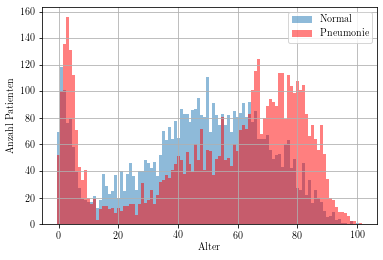

In [60]:
maximum_age = max(max(set(filtered_df['Age'])), max(set(pneumonia_meta_data['Age'])))
x_axis_age = np.arange(maximum_age + 2)-0.5 # would be +1 for right aligned, but we want to center the x ticks -> +0.5

plt.hist(filtered_df['Age'], x_axis_age, alpha=0.5, label="Normal")
plt.hist(pneumonia_meta_data['Age'], x_axis_age, alpha=0.5, color='r', label="Pneumonie")
plt.ylabel('Anzahl Patienten')
plt.xlabel('Alter')
plt.legend()
plt.grid(True)

if USE_LATEX_ENGINE:
    plt.savefig('/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_age_histogram_no_groups.pdf')

In [61]:
total_error = 0
for age in np.arange(max(max(filtered_df['Age']), max(pneumonia_meta_data['Age']))):
    error = abs(list(filtered_df['Age']).count(age) - list(pneumonia_meta_data['Age']).count(age))
    # print(error)
    total_error += error
print('Total error was:', total_error)

Total error was: 2848


In [62]:
qry = "(Manufacturer_DICOM == 'ImagingDynamicsCompanyLtd' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & AgeGroup == '3.0')"
qry = qry + " | (Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & AgeGroup == '2.0')"
qry = qry + " | (Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'M' & ProjectionSimplified == 'AP' & AgeGroup == '2.0')"
dropped_samples = normal_meta_data.query(qry)
normal_meta_data.drop(dropped_samples.index, inplace=True)

print(len(dropped_samples), 'samples were temporarily removed')

27 samples were temporarily removed


In [63]:
filtered_df = stratified_sample_transferred(normal_meta_data, pneumonia_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'ProjectionSimplified', 'AgeGroup'], size=len(pneumonia_meta_data) + 174) # 174 was determined empirically so the length of the filtered dataframe + all remaining ap samples matches the length of pneumonia data
# missing values: 'MethodLabel'

Warning! The required number of samples (420) could not be retrieved.
Using all available entries (256) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & AgeGroup == 3.0
Warning! The required number of samples (646) could not be retrieved.
Using all available entries (311) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'CR' & PatientSex_DICOM == 'M' & ProjectionSimplified == 'AP' & AgeGroup == 3.0
Warning! The required number of samples (10) could not be retrieved.
Using all available entries (1) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'F' & ProjectionSimplified == 'AP' & AgeGroup == 1.0
Warning! The required number of samples (10) could not be retrieved.
Using all available entries (3) of group:
Manufacturer_DICOM == 'PhilipsMedicalSystems' & Modality_DICOM == 'DX' & PatientSex_DICOM == 'M' & ProjectionSim

In [64]:
len(filtered_df)

4876

In [65]:
stratified_sample_report(pneumonia_meta_data, ['Manufacturer_DICOM', 'Modality_DICOM', 'PatientSex_DICOM', 'AgeGroup', 'ProjectionSimplified'], size=len(pneumonia_meta_data))

,Manufacturer_DICOM,Modality_DICOM,PatientSex_DICOM,AgeGroup,ProjectionSimplified,size,samp_size
0,ImagingDynamicsCompanyLtd,CR,F,1.0,AP,1,1
1,ImagingDynamicsCompanyLtd,CR,F,1.0,PA,36,36
2,ImagingDynamicsCompanyLtd,CR,F,2.0,AP,1,1
3,ImagingDynamicsCompanyLtd,CR,F,2.0,PA,305,305
4,ImagingDynamicsCompanyLtd,CR,F,3.0,PA,187,187
5,ImagingDynamicsCompanyLtd,CR,M,1.0,AP,8,8
6,ImagingDynamicsCompanyLtd,CR,M,1.0,PA,42,42
7,ImagingDynamicsCompanyLtd,CR,M,2.0,AP,4,4
8,ImagingDynamicsCompanyLtd,CR,M,2.0,PA,234,234
9,ImagingDynamicsCompanyLtd,CR,M,3.0,AP,1,1


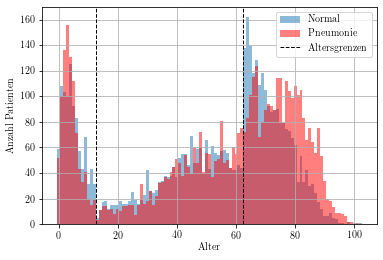

In [66]:
maximum_age = max(max(set(filtered_df['Age'])), max(set(pneumonia_meta_data['Age'])))
x_axis_age = np.arange(maximum_age + 2)-0.5 # would be +1 for right aligned, but we want to center the x ticks -> +0.5


plt.hist(filtered_df['Age'], x_axis_age, alpha=0.5, label="Normal")
plt.hist(pneumonia_meta_data['Age'], x_axis_age, alpha=0.5, color='r', label="Pneumonie")
plt.axvline(x=FIRST_GROUP_BOUNDARY + 0.5, label='Altersgrenzen', c='k', linestyle='--', linewidth=1)
plt.axvline(x=SECOND_GROUP_BOUNDARY + 0.5, c='k', linestyle='--', linewidth=1)
plt.ylabel('Anzahl Patienten')
plt.xlabel('Alter')

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]     # order in the array determines position, number in the array is the original order
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.grid(True)


if USE_LATEX_ENGINE:
    plt.savefig('/mnt/c/Users/Jan/Daten/Dropbox/Master/3_Semester/Masterarbeit/Latex/python_output/padchest_age_histogram_with_groups.pdf')

In [67]:
total_error = 0
for age in np.arange(max(max(filtered_df['Age']), max(pneumonia_meta_data['Age']))):
    error = abs(list(filtered_df['Age']).count(age) - list(pneumonia_meta_data['Age']).count(age))
    # print(error)
    total_error += error
print('Total error was:', total_error)



Total error was: 1645


In [68]:
calculate_percentages(normal_meta_data['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'], filtered_df['ProjectionSimplified'])

{'PA', 'AP'}
                     normal (total)                normal (filtered)             pneumonia                     
PA:                  33483/35190 (95.15%)          3513/4876 (72.05%)            3400/5220 (65.13%)            
AP:                  1707/35190 (4.85%)            1363/4876 (27.95%)            1820/5220 (34.87%)            


In [69]:
remaining_ap_df = normal_meta_data.copy()
remaining_ap_df.drop(filtered_df['index'], inplace=True)

In [70]:
remaining_ap = remaining_ap_df.query("ProjectionSimplified == 'AP'")
print(len(remaining_ap))
filtered_df = filtered_df.append(remaining_ap)

344


In [71]:
calculate_percentages(normal_meta_data['ProjectionSimplified'], pneumonia_meta_data['ProjectionSimplified'], filtered_df['ProjectionSimplified'])
calculate_percentages(filtered_df['MethodLabel'], pneumonia_meta_data['MethodLabel'])
calculate_percentages(filtered_df['MethodProjection'], pneumonia_meta_data['MethodProjection'])
calculate_percentages(filtered_df['Manufacturer_DICOM'], pneumonia_meta_data['Manufacturer_DICOM'])
calculate_percentages(filtered_df['PatientSex_DICOM'], pneumonia_meta_data['PatientSex_DICOM'])


{'PA', 'AP'}
                     normal (total)                normal (filtered)             pneumonia                     
PA:                  33483/35190 (95.15%)          3513/5220 (67.30%)            3400/5220 (65.13%)            
AP:                  1707/35190 (4.85%)            1707/5220 (32.70%)            1820/5220 (34.87%)            
{'Physician', 'RNN_model'}
                     normal                        pneumonia                     
Physician:           1239/5220 (23.74%)            1094/5220 (20.96%)            
RNN_model:           3981/5220 (76.26%)            4126/5220 (79.04%)            
{'Manual review of DICOM fields', 'resnet-50.t7'}
                     normal                        pneumonia                     
Manual review of DICOM fields: 4488/5220 (85.98%)            4761/5220 (91.21%)            
resnet-50.t7:        732/5220 (14.02%)             459/5220 (8.79%)              
{'PhilipsMedicalSystems', 'ImagingDynamicsCompanyLtd'}
                 

In [72]:
calculate_percentages(filtered_df['BitsStored_DICOM'], pneumonia_meta_data['BitsStored_DICOM'])
calculate_percentages(filtered_df['SpatialResolution_DICOM'], pneumonia_meta_data['SpatialResolution_DICOM'])


{10, 12}
                     normal                        pneumonia                     
10:                  917/5220 (17.57%)             583/5220 (11.17%)             
12:                  4303/5220 (82.43%)            4637/5220 (88.83%)            
{'0.15', '0.1500000059604', '0.143', 'None', '0.2', '0.2000000029802', '0.148', '0.182', '0.1500000059605'}
                     normal                        pneumonia                     
0.15:                370/5220 (7.09%)              262/5220 (5.02%)              
0.1500000059604:     10/5220 (0.19%)               3/5220 (0.06%)                
0.143:               733/5220 (14.04%)             1265/5220 (24.23%)            
None:                2168/5220 (41.53%)            1699/5220 (32.55%)            
0.2:                 1337/5220 (25.61%)            1552/5220 (29.73%)            
0.2000000029802:     360/5220 (6.90%)              143/5220 (2.74%)              
0.148:               223/5220 (4.27%)              232/5220 (4.

In [73]:
calculate_percentages(filtered_df['ViewPosition_DICOM'], pneumonia_meta_data['ViewPosition_DICOM'])

{'PA', 'ANTEROPOSTERIOR', 'U', 'AP', 'POSTEROANTERIOR'}
                     normal                        pneumonia                     
PA:                  216/5220 (4.14%)              209/5220 (4.00%)              
ANTEROPOSTERIOR:     116/5220 (2.22%)              15/5220 (0.29%)               
U:                   3746/5220 (71.76%)            3872/5220 (74.18%)            
AP:                  7/5220 (0.13%)                25/5220 (0.48%)               
POSTEROANTERIOR:     1135/5220 (21.74%)            1099/5220 (21.05%)            


# Store results as csv files

In [74]:
filtered_df.to_csv('./normal_meta_data_filtered.csv')
pneumonia_meta_data.to_csv('./pneumonia_meta_data_filtered.csv')